# INCLUDE
Instruction to colab user:
- Run the first cell to install auto-sklearn on colab, and auto restart runtime, then proceed to run the following cells
- Run the second cell to mount google drive for I/O of dataset, results. In this notebook, dataset can be load from pickle and results can be dump to pickle.

Instruction to non-colab user:
- Ignore first two cell
- Change the paths


## Run for colab

In [ ]:
# For Colab, you need to install auto-sklearn every time
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install auto-sklearn # Downgrade scipy to 1.4.x
    #!pip install scipy # Upgrade scipy to 1.7.x

import os, signal
os.kill(os.getpid(), signal.SIGKILL) # Restart_runtime

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Run for everyone

In [3]:
# Dependencies
# Common
import os
import pickle
import sys
import time
from tqdm.autonotebook import tqdm
from datetime import datetime

import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn # Import sklearn before autosklearn, solve scipy version error
from sklearn.model_selection import train_test_split
import sklearn.datasets
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# AML
import autosklearn
import autosklearn.classification
from autosklearn.metrics import balanced_accuracy, precision, recall

# Wilcoxon test
from scipy.stats import wilcoxon

# Check machine
#import multiprocessing
#multiprocessing.cpu_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Set paths

In [4]:
# Set up paths

# User insert folder to store pickles
# dataset name in format openml_xxx.pkl
datasets_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/data'
results_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/results'

In [41]:
# Look up results directory
os.listdir(results_folder)

['openml_meta_features.pkl',
 'experiment_20211214-212505.pkl',
 'experiment_20211215-021346.pkl',
 'experiment_20211215-093355.pkl',
 'experiment_20211215-095915.pkl',
 'experiment_20211215-155528.pkl']

# Functions

In [8]:
def Load_result_pkl(folder_path, result_name):
    fname = os.path.join(folder_path, result_name)
    file_read = open(fname, "rb")
    res = pickle.load(file_read) # Load pickle to data
    file_read.close()
    return res

def Prep_res_df(res, meta_features_df):
    res_df = pd.DataFrame({k:{'mean_acc': np.mean(v['acc']), 'sd_acc': np.std(v['acc'])} for k,v in res.items()}).T
    res_df.reset_index(inplace=True)
    res_df.rename(columns={'index': 'dataset'}, inplace=True)
    res_df = res_df.merge(
        meta_features_df, 
        how='inner', on='dataset')
    return res_df

In [33]:
res_df.head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
0,41168,0.565081,0.0,83733,54,4
1,1596,0.142857,0.0,581012,54,7
2,41150,0.939547,0.0,130064,50,2
3,40668,0.678986,0.0,67557,42,3
4,3,0.986758,0.0,3196,36,2


In [37]:
def Compare_acc_meta_feature(res_df, y1, y2, sortby='dataset'):
    # Plot test acc avg on each dataset
    fig, ax1 = plt.subplots(figsize=(20,4))
    ax2 = ax1.twinx()

    sns.scatterplot(x='dataset', y=y1,
                    data=res_df.sort_values(sortby),
#                    data=res_df.sort_values('mean_acc'),
                    color='r',
                    ax=ax1)
    sns.scatterplot(x='dataset', y=y2, 
                    data=res_df.sort_values(sortby), 
#                    data=res_df.sort_values('mean_acc'),
                    color='b',
                    ax=ax2)

    ax2.set(yscale='log')

    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Balanced accuracy')
    ax2.set_ylabel(y2)

    ax1.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

    fig.legend([y1, y2],
            loc='lower right')

    fig.tight_layout()

    return fig

def Scatter_acc_meta_feature(res_df):
    x, y, z = res_df['n_instance'], res_df['n_feature'], res_df['mean_acc']

    fig, ax = plt.subplots()

    plt.scatter(x=x, y=y, c=z,
                cmap='inferno')

    ax.set(xscale='log', yscale='log')

    ax.set_xlabel('n_instance')
    ax.set_ylabel('n_feature')
    ax.set_facecolor('silver')

    plt.colorbar(ax=ax)

    plt.tight_layout()

    return fig

# Load meta features

In [10]:
folder_path = results_folder

fname = os.path.join(folder_path, 'openml_meta_features.pkl')
file_read = open(fname, "rb")
meta_features = pickle.load(file_read) # Load pickle to data
file_read.close()

In [11]:
meta_features_df = pd.DataFrame(meta_features).T
meta_features_df.reset_index(inplace=True)
meta_features_df.rename(columns={'index': 'dataset'}, inplace=True)
meta_features_df.head()

,dataset,n_instance,n_feature,n_class
0,41168,83733,54,4
1,1596,581012,54,7
2,41150,130064,50,2
3,40668,67557,42,3
4,3,3196,36,2


# Experiment 1 part 1: budget = 60s

## Process results

In [ ]:
load_result = 'experiment_20211202-220329.pkl'
res1 = Load_result_pkl(results_folder, load_result)
res1_df = Prep_res_df(res1, meta_features_df)

## Inspect results

In [ ]:
res_df = res1_df

In [ ]:
# Worst 5
res_df.sort_values('mean_acc').head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
14,41167,0.002817,0.0,416188,60,355
21,41169,0.080339,0.0,65196,27,100
0,41165,0.100000,0.0,10000,7200,10
7,40996,0.100000,0.0,70000,784,10
32,40685,0.142857,0.0,58000,9,7


In [ ]:
# Best 5
res_df.sort_values('mean_acc').tail()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
5,1468,0.951517,0.010539,1080,856,9
9,12,0.979841,0.006431,2000,216,10
26,40984,0.981813,0.002698,2310,18,7
19,3,0.985300,0.001506,3196,36,2
34,40975,0.985431,0.006899,1728,6,4


In [ ]:
res1['3']['cls'][1].leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.58,random_forest,0.012135,3.992263
9,2,0.06,lda,0.075517,2.200134
3,3,0.36,adaboost,0.109730,3.742078


## Figures

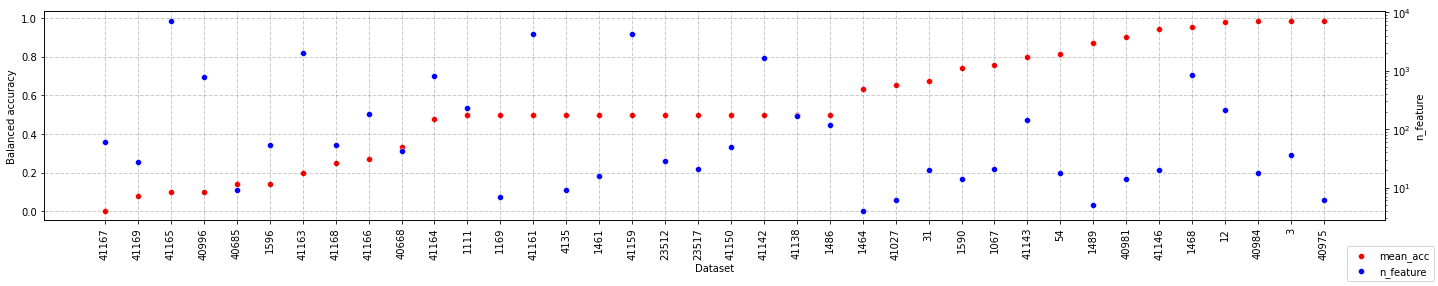

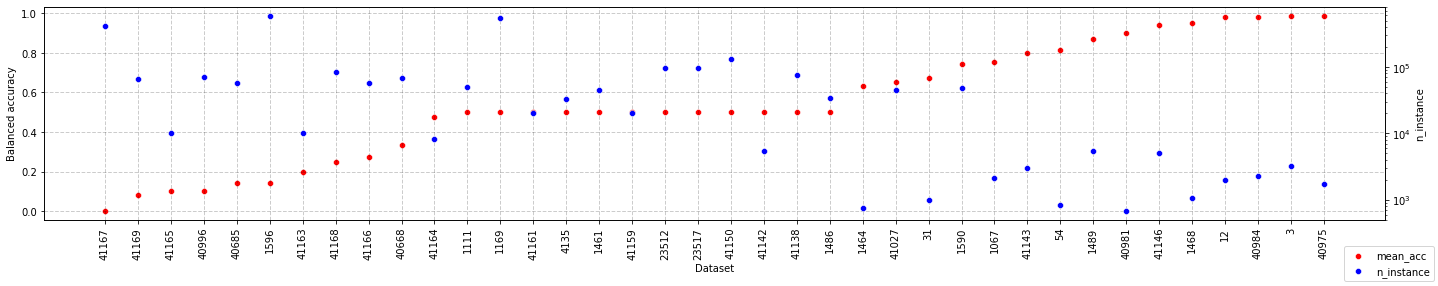

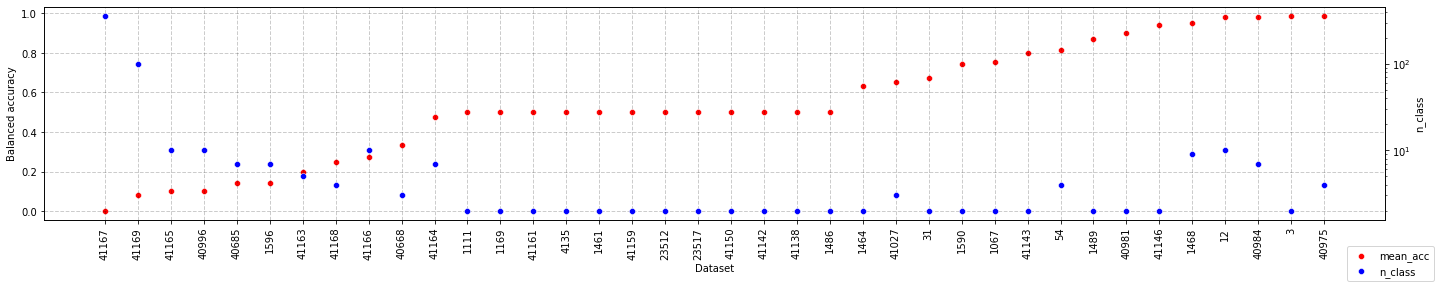

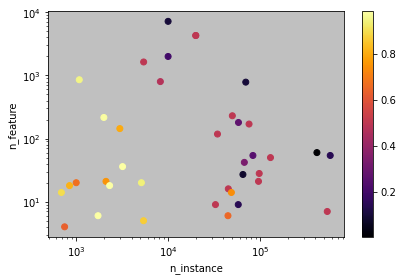

In [ ]:
res_df = res1_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

In [ ]:
# Not used

# Plot test acc distribution on each dataset
fig, ax = plt.subplots(figsize=(20,8))
sns.violinplot(x='dataset', y='mean_acc', 
               data=res_df.sort_values('mean_acc'), 
               ax=ax)

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Dataset')
ax.set_ylabel('Balanced accuracy')

ax.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

fig.tight_layout()

fig_name = 'res_plot_' + fname + '.png'
#fig.savefig(fig_name)

# Experiment 1 part 2: budget = 240s
- increased to time budget = 240s

## Process results

In [ ]:
load_result = 'experiment_20211203-081432.pkl'
res2 = Load_result_pkl(results_folder, load_result)
res2_df = Prep_res_df(res2, meta_features_df)

## Figures

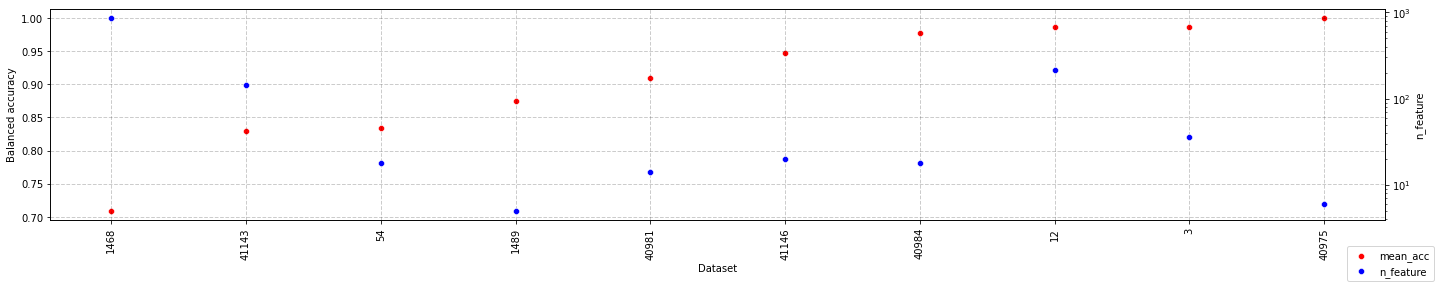

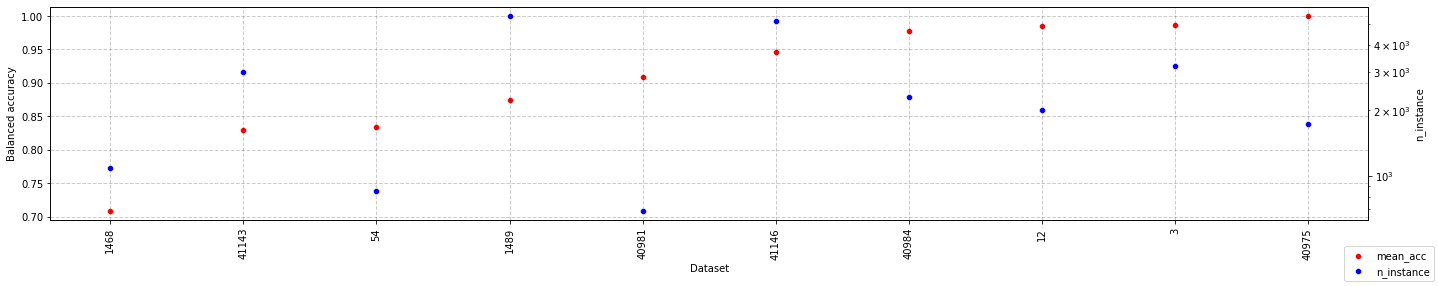

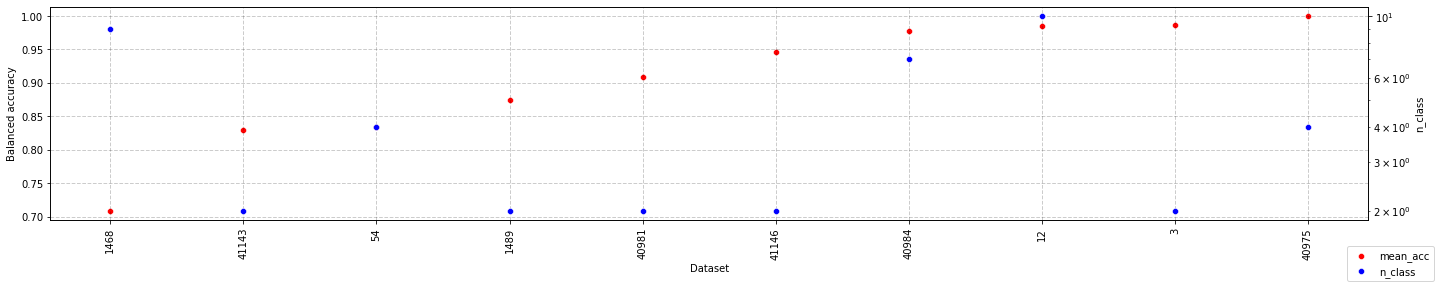

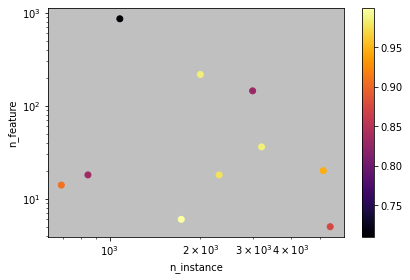

In [ ]:
res_df = res2_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

# Wilcoxon signed-rank test
To test the null hypothesis that there is no difference between two set of values, we can apply the two-sided test.

In [ ]:
# Filter out results on same dataset in two differnt run
datasets_to_compare = np.intersect1d(res1_df['dataset'], res2_df['dataset'])
# Construct result table
compare_res_df = res1_df[['dataset', 'mean_acc', 'sd_acc']].merge(
    res2_df[['dataset', 'mean_acc', 'sd_acc']], 
    on='dataset', how='inner',
    suffixes=('_exp1', '_exp2'))
# Compute difference
compare_res_df['improvement'] = compare_res_df['mean_acc_exp2'] - compare_res_df['mean_acc_exp1']
# Compute p-values for Wilcoxon signed-rank test
pvals = {dataset: wilcoxon(res1[dataset]['acc'], 
                   res2[dataset]['acc'], 
                   alternative='two-sided')[1] for dataset in datasets_to_compare}
# Merge to result table
compare_res_df['pval_signedrank'] = compare_res_df['dataset'].map(pvals).fillna('')


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
# Show result
compare_res_df

,dataset,mean_acc_exp1,sd_acc_exp1,mean_acc_exp2,sd_acc_exp2,improvement,pval_signedrank
0,1468,0.951517,0.010539,0.709182,0.301034,-0.242335,0.062500
1,12,0.979841,0.006431,0.985477,0.003484,0.005637,0.312500
2,41143,0.798071,0.002982,0.829970,0.002243,0.031899,0.062500
3,3,0.985300,0.001506,0.986602,0.001189,0.001302,0.108809
4,41146,0.943067,0.003071,0.946819,0.002472,0.003751,0.125000
5,40984,0.981813,0.002698,0.977665,0.001179,-0.004147,0.067889
6,54,0.813181,0.019257,0.834590,0.021481,0.021409,0.125000
7,40981,0.899937,0.005826,0.908641,0.005958,0.008704,0.062500
8,40975,0.985431,0.006899,0.999438,0.001124,0.014007,0.062500
9,1489,0.868555,0.018134,0.874925,0.003547,0.006370,0.812500


# Experiment 1 part 3: budget = 600s
- increased time budget = 600s
- memory limit = None

## Process results

In [42]:
load_result = 'experiment_20211215-021346.pkl'
res = Load_result_pkl(results_folder, load_result)
res_df = Prep_res_df(res, meta_features_df)

In [49]:
# Sort by performance ascending 
res_df.sort_values('mean_acc').head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
6,41169,0.080339,0.0,65196,27,100
31,40996,0.100000,0.0,70000,784,10
24,41165,0.100000,0.0,10000,7200,10
1,1596,0.142857,0.0,581012,54,7
23,41167,0.325630,0.0,416188,60,355


In [44]:
res_df.shape

(38, 6)

In [45]:
print(res['41169']['cls'][0])
print(res['41169']['cls'][0].sprint_statistics())

AutoSklearnClassifier(memory_limit=None, metric=balanced_accuracy,
                      per_run_time_limit=60,
                      scoring_functions=[precision, recall], seed=3003105692,
                      time_left_for_this_task=600)
auto-sklearn results:
  Dataset name: 41169
  Metric: balanced_accuracy
  Best validation score: 0.081789
  Number of target algorithm runs: 11
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0



In [46]:
# Bad result => only return 1 pipeline
res['41169']['cls'][0].leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
3,1,1.0,lda,0.918211,2.478441,2,0.920578,0,1.639538e+09,1.639538e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],weighting,Initial design


In [47]:
res['3']['cls'][0].leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
30,1,0.04,gradient_boosting,0.002463,13.099522,29,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Local Search
16,2,0.06,gradient_boosting,0.003605,3.094070,15,0.001170,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
12,3,0.02,gradient_boosting,0.003695,9.692729,11,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Initial design
33,4,0.04,gradient_boosting,0.003695,5.430563,32,0.000607,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Local Search
18,5,0.08,gradient_boosting,0.006849,2.477359,17,0.006281,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
25,6,0.02,libsvm_svc,0.009582,1.371901,24,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],none,Initial design
23,7,0.08,extra_trees,0.013969,5.068969,22,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Initial design
21,8,0.02,gradient_boosting,0.014238,3.632012,20,0.004592,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],weighting,Initial design
19,9,0.04,decision_tree,0.023281,1.450419,18,0.015334,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design


## Figures

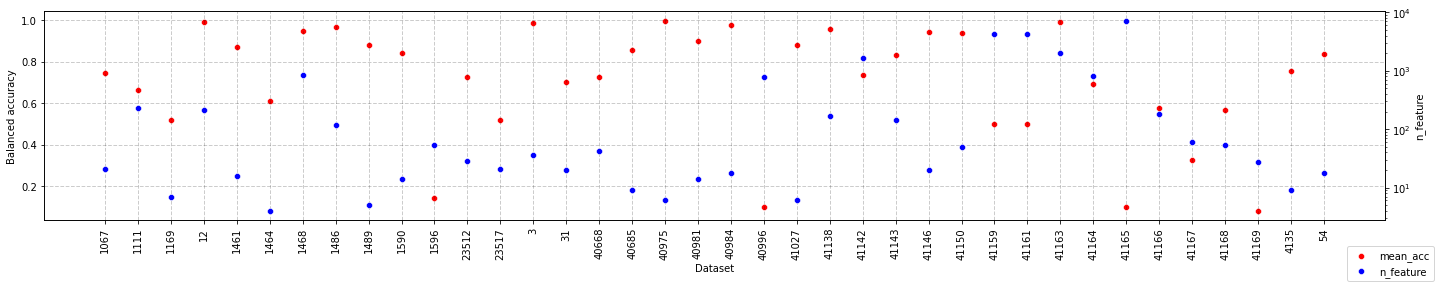

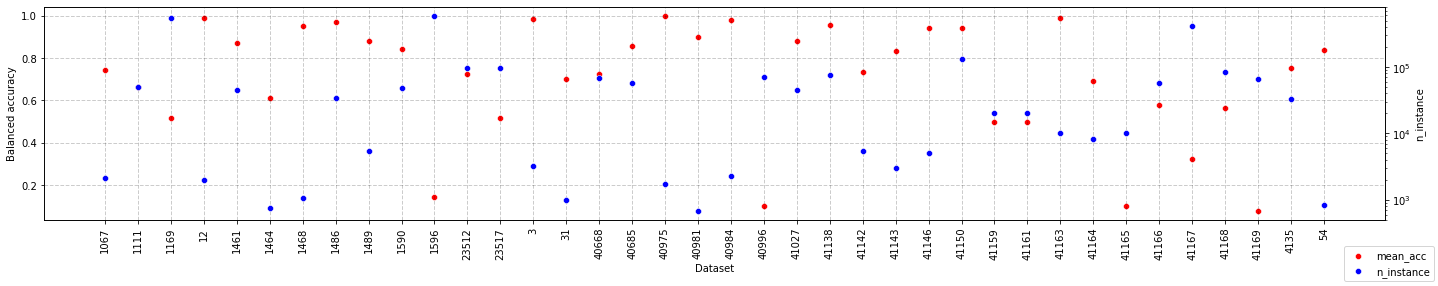

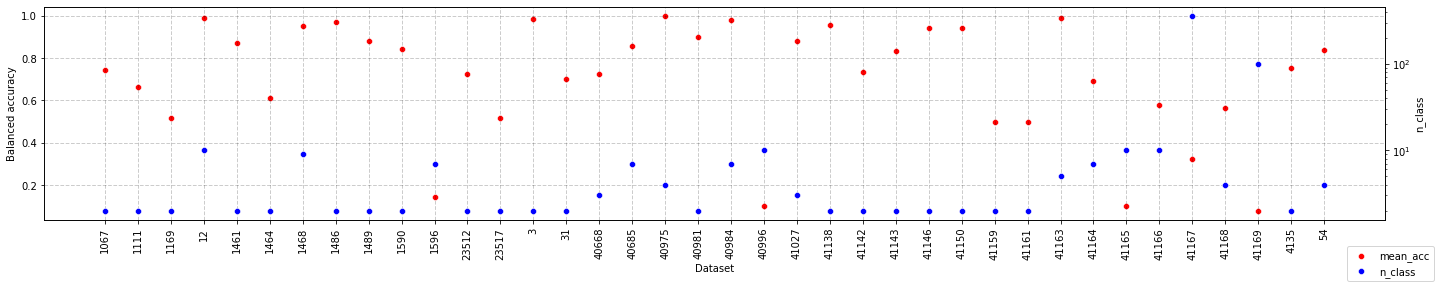

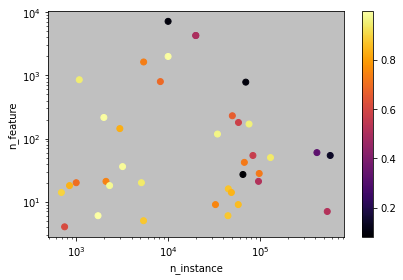

In [48]:
res_df = res_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

# Experiment 2: ensemble n_best = 10%
- increased time budget = 600s
- no mem limit
- ensemble_nbest = 0.1

## Process results

In [19]:
# Result part 1
load_result = 'experiment_20211215-095915.pkl'
res = Load_result_pkl(results_folder, load_result)
res_df1 = Prep_res_df(res, meta_features_df)

In [20]:
# Result part 2
load_result = 'experiment_20211215-155528.pkl'
res = Load_result_pkl(results_folder, load_result)
res_df2 = Prep_res_df(res, meta_features_df)

In [23]:
res_df = pd.concat([res_df1, res_df2]).reset_index(drop=True)

In [26]:
# Worst 5
res_df.sort_values('mean_acc').head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
6,41169,0.080339,0.0,65196,27,100
31,40996,0.100000,0.0,70000,784,10
24,41165,0.100000,0.0,10000,7200,10
1,1596,0.142857,0.0,581012,54,7
23,41167,0.325630,0.0,416188,60,355


In [27]:
res_df.shape

(38, 6)

In [31]:
# Run info
print(res['41164']['cls'][0])
print(res['41164']['cls'][0].sprint_statistics())

AutoSklearnClassifier(ensemble_nbest=0.1, memory_limit=None,
                      metric=balanced_accuracy, per_run_time_limit=60,
                      scoring_functions=[precision, recall], seed=3003105692,
                      time_left_for_this_task=600)
auto-sklearn results:
  Dataset name: 41164
  Metric: balanced_accuracy
  Best validation score: 0.653151
  Number of target algorithm runs: 16
  Number of successful target algorithm runs: 8
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 7
  Number of target algorithms that exceeded the memory limit: 0



## Figures

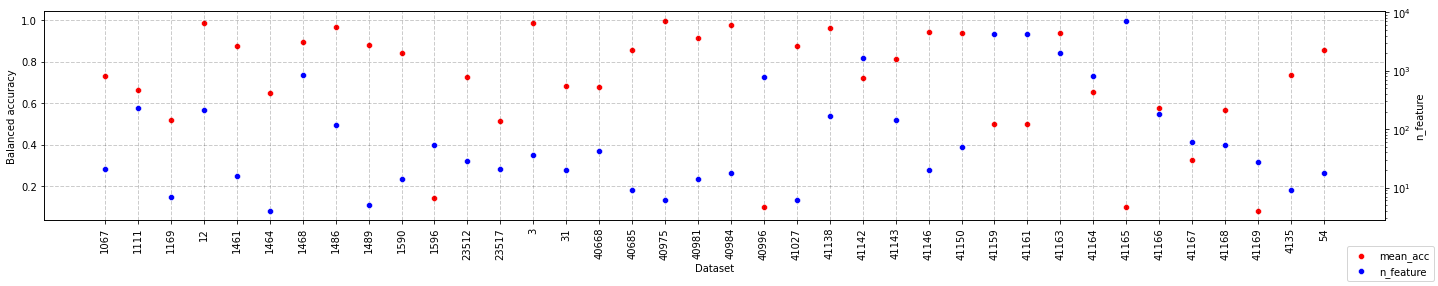

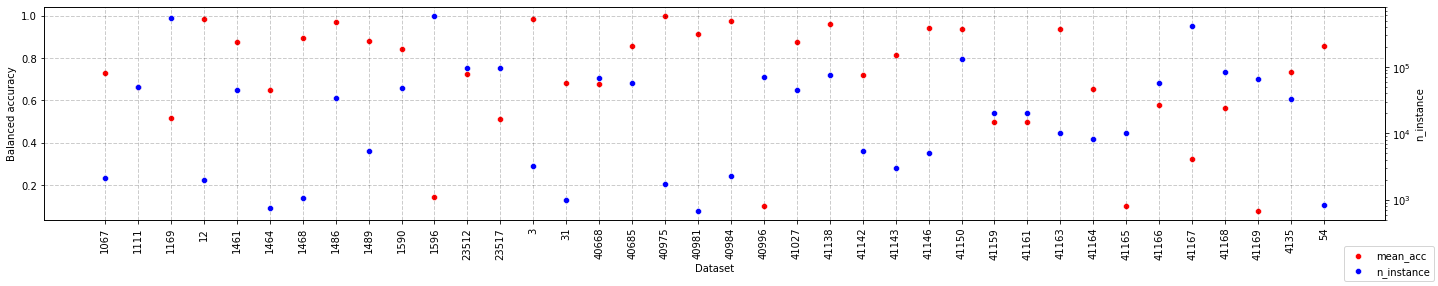

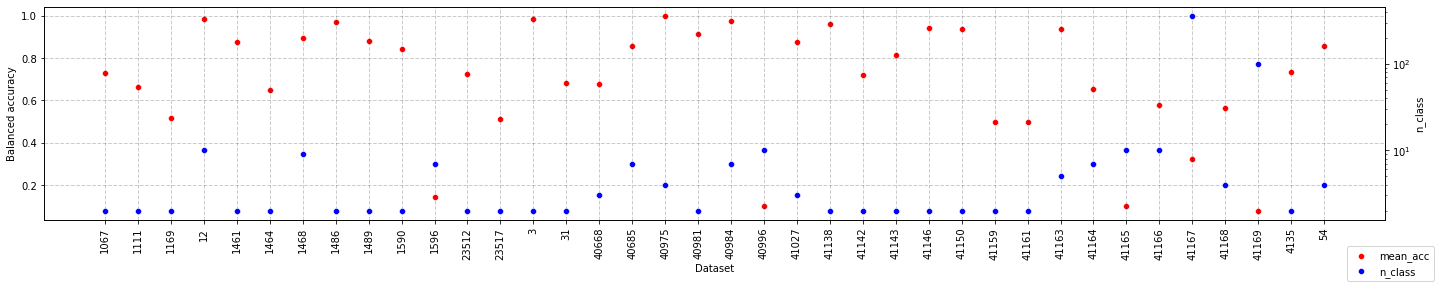

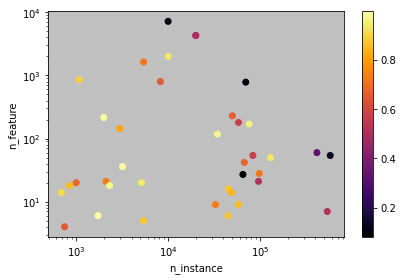

In [39]:
res_df = res_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)